# 「tflite micro」であそぼう！

## 元のプロジェクト：[github.com/arduino/ArduinoTensorFlowLiteTutorials](https://github.com/arduino/ArduinoTensorFlowLiteTutorials/tree/master/GestureToEmoji)
### ESP32バーション：[@proppy](https://twitter.com/proppy])

# 「tflite micro」ってなんだ？

- マイコンで「tflite」が動く事
![img](https://d2air1d4eqhwg2.cloudfront.net/images/5517/500x500/f38b9598-6d09-4f5a-9427-5e16d9bba835.jpg)
- https://www.tensorflow.org/lite/microcontrollers


In [1]:
! python -m pip install tensorflow==2.0.0
import tensorflow as tf
print(tf.version.VERSION)

! python -m pip install matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams["figure.figsize"] = (20,10)

! python -m pip install pandas
import pandas as pd

import numpy as np

2.0.0


# まずはデータを集めよう

```
void setup() {
  M5.begin();
  Serial.begin(9600);
  M5.IMU.Init();
  M5.Mpu6886.SetAccelFsr(M5.Mpu6886.AFS_4G);
  M5.Mpu6886.SetGyroFsr(M5.Mpu6886.GFS_2000DPS);
  
  Serial.println("aX,aY,aZ,gX,gY,gZ");
}
```

```
void loop() {
      // ...
      M5.IMU.getAccelData(&aX,&aY,&aZ);
      M5.IMU.getGyroData(&gX,&gY,&gZ);
      //....
      Serial.println()
}
```


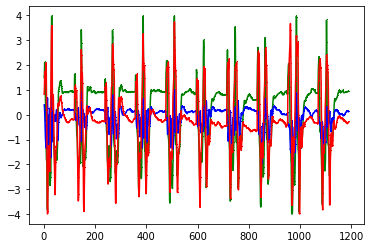

In [2]:
df = pd.read_csv("maru.csv")

index = range(1, len(df['aX']) + 1)
plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "maru",
    "batsu",
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv(gesture + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.0.0

Processing index 0 for gesture 'maru'.
	There are 10 recordings of the maru gesture.
Processing index 1 for gesture 'batsu'.
	There are 10 recordings of the batsu gesture.
Data set parsing and preparation complete.


## datasetをちゃんと分けて

In [4]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Kerasで２分を温めて

In [5]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Train on 12 samples, validate on 4 samples
Epoch 1/600
12/12 [==============================] - 0s 39ms/sample - loss: 0.3171 - mae: 0.5525 - val_loss: 0.2452 - val_mae: 0.4947
Epoch 2/600
12/12 [==============================] - 0s 3ms/sample - loss: 0.2623 - mae: 0.5060 - val_loss: 0.2474 - val_mae: 0.4946
Epoch 3/600
12/12 [==============================] - 0s 3ms/sample - loss: 0.2588 - mae: 0.5071 - val_loss: 0.2398 - val_mae: 0.4890
Epoch 4/600
12/12 [==============================] - 0s 3ms/sample - loss: 0.2274 - mae: 0.4579 - val_loss: 0.2396 - val_mae: 0.4689
Epoch 5/600
12/12 [==============================] - 0s 3ms/sample - loss: 0.2364 - mae: 0.4790 - val_loss: 0.2051 - val_mae: 0.4466
Epoch 6/600
12/12 [==============================] - 0s 3ms/sample - loss: 0.2007 - mae: 0.4390 - val_loss: 0.1846 - val_mae: 0.4270
Epoch 7/600
12/12 [==============================] - 0s 3ms/sample - loss: 0.1851 - mae: 0.4264 - val_loss: 0.1717 - val_mae: 0.4076
Epoch 8/600
12/12 [======

Epoch 61/600
12/12 [==============================] - 0s 4ms/sample - loss: 4.6974e-06 - mae: 0.0014 - val_loss: 0.0017 - val_mae: 0.0227
Epoch 62/600
12/12 [==============================] - 0s 2ms/sample - loss: 6.6962e-07 - mae: 6.5456e-04 - val_loss: 0.0047 - val_mae: 0.0355
Epoch 63/600
12/12 [==============================] - 0s 3ms/sample - loss: 1.0023e-06 - mae: 7.4007e-04 - val_loss: 0.0075 - val_mae: 0.0442
Epoch 64/600
12/12 [==============================] - 0s 2ms/sample - loss: 7.2828e-07 - mae: 6.2937e-04 - val_loss: 0.0115 - val_mae: 0.0542
Epoch 65/600
12/12 [==============================] - 0s 3ms/sample - loss: 8.1537e-07 - mae: 6.2036e-04 - val_loss: 0.1368 - val_mae: 0.1866
Epoch 66/600
12/12 [==============================] - 0s 3ms/sample - loss: 4.2640e-05 - mae: 0.0027 - val_loss: 3.0108e-04 - val_mae: 0.0108
Epoch 67/600
12/12 [==============================] - 0s 3ms/sample - loss: 3.3552e-07 - mae: 3.8229e-04 - val_loss: 3.7949e-04 - val_mae: 0.0117
Epoch 

12/12 [==============================] - 0s 3ms/sample - loss: 4.8337e-10 - mae: 1.6334e-05 - val_loss: 3.1464e-04 - val_mae: 0.0090
Epoch 118/600
12/12 [==============================] - 0s 3ms/sample - loss: 4.6726e-10 - mae: 1.6089e-05 - val_loss: 3.1221e-04 - val_mae: 0.0090
Epoch 119/600
12/12 [==============================] - 0s 2ms/sample - loss: 4.4539e-10 - mae: 1.5735e-05 - val_loss: 2.9157e-04 - val_mae: 0.0087
Epoch 120/600
12/12 [==============================] - 0s 3ms/sample - loss: 4.3717e-10 - mae: 1.5486e-05 - val_loss: 2.8450e-04 - val_mae: 0.0086
Epoch 121/600
12/12 [==============================] - 0s 3ms/sample - loss: 4.2445e-10 - mae: 1.5255e-05 - val_loss: 2.8893e-04 - val_mae: 0.0086
Epoch 122/600
12/12 [==============================] - 0s 2ms/sample - loss: 4.1196e-10 - mae: 1.5038e-05 - val_loss: 2.8378e-04 - val_mae: 0.0085
Epoch 123/600
12/12 [==============================] - 0s 2ms/sample - loss: 3.9932e-10 - mae: 1.4768e-05 - val_loss: 2.8653e-04 - v

Epoch 173/600
12/12 [==============================] - 0s 3ms/sample - loss: 1.5981e-10 - mae: 9.1866e-06 - val_loss: 2.1322e-04 - val_mae: 0.0074
Epoch 174/600
12/12 [==============================] - 0s 2ms/sample - loss: 1.5798e-10 - mae: 9.1428e-06 - val_loss: 2.1304e-04 - val_mae: 0.0074
Epoch 175/600
12/12 [==============================] - 0s 2ms/sample - loss: 1.5612e-10 - mae: 9.0711e-06 - val_loss: 2.1160e-04 - val_mae: 0.0074
Epoch 176/600
12/12 [==============================] - 0s 2ms/sample - loss: 1.5406e-10 - mae: 9.0172e-06 - val_loss: 2.1135e-04 - val_mae: 0.0074
Epoch 177/600
12/12 [==============================] - 0s 3ms/sample - loss: 1.5259e-10 - mae: 8.9670e-06 - val_loss: 2.1098e-04 - val_mae: 0.0073
Epoch 178/600
12/12 [==============================] - 0s 3ms/sample - loss: 1.5067e-10 - mae: 8.9032e-06 - val_loss: 2.0956e-04 - val_mae: 0.0073
Epoch 179/600
12/12 [==============================] - 0s 2ms/sample - loss: 1.4887e-10 - mae: 8.8638e-06 - val_loss: 

Epoch 229/600
12/12 [==============================] - 0s 3ms/sample - loss: 9.4582e-11 - mae: 6.9942e-06 - val_loss: 1.7756e-04 - val_mae: 0.0067
Epoch 230/600
12/12 [==============================] - 0s 2ms/sample - loss: 9.3763e-11 - mae: 6.9707e-06 - val_loss: 1.7709e-04 - val_mae: 0.0067
Epoch 231/600
12/12 [==============================] - 0s 2ms/sample - loss: 9.3087e-11 - mae: 6.9383e-06 - val_loss: 1.7660e-04 - val_mae: 0.0067
Epoch 232/600
12/12 [==============================] - 0s 2ms/sample - loss: 9.2325e-11 - mae: 6.9005e-06 - val_loss: 1.7613e-04 - val_mae: 0.0067
Epoch 233/600
12/12 [==============================] - 0s 2ms/sample - loss: 9.1608e-11 - mae: 6.8712e-06 - val_loss: 1.7608e-04 - val_mae: 0.0067
Epoch 234/600
12/12 [==============================] - 0s 3ms/sample - loss: 9.1067e-11 - mae: 6.8546e-06 - val_loss: 1.7559e-04 - val_mae: 0.0067
Epoch 235/600
12/12 [==============================] - 0s 3ms/sample - loss: 9.0440e-11 - mae: 6.8341e-06 - val_loss: 

Epoch 285/600
12/12 [==============================] - 0s 2ms/sample - loss: 6.6566e-11 - mae: 5.8223e-06 - val_loss: 1.6025e-04 - val_mae: 0.0064
Epoch 286/600
12/12 [==============================] - 0s 2ms/sample - loss: 6.6158e-11 - mae: 5.8005e-06 - val_loss: 1.6005e-04 - val_mae: 0.0064
Epoch 287/600
12/12 [==============================] - 0s 2ms/sample - loss: 6.5834e-11 - mae: 5.7936e-06 - val_loss: 1.5969e-04 - val_mae: 0.0064
Epoch 288/600
12/12 [==============================] - 0s 3ms/sample - loss: 6.5553e-11 - mae: 5.7745e-06 - val_loss: 1.5931e-04 - val_mae: 0.0064
Epoch 289/600
12/12 [==============================] - 0s 3ms/sample - loss: 6.5249e-11 - mae: 5.7613e-06 - val_loss: 1.5911e-04 - val_mae: 0.0064
Epoch 290/600
12/12 [==============================] - 0s 2ms/sample - loss: 6.4997e-11 - mae: 5.7486e-06 - val_loss: 1.5893e-04 - val_mae: 0.0064
Epoch 291/600
12/12 [==============================] - 0s 2ms/sample - loss: 6.4480e-11 - mae: 5.7301e-06 - val_loss: 

Epoch 341/600
12/12 [==============================] - 0s 3ms/sample - loss: 5.1353e-11 - mae: 5.0861e-06 - val_loss: 1.4692e-04 - val_mae: 0.0061
Epoch 342/600
12/12 [==============================] - 0s 3ms/sample - loss: 5.0987e-11 - mae: 5.0650e-06 - val_loss: 1.4664e-04 - val_mae: 0.0061
Epoch 343/600
12/12 [==============================] - 0s 3ms/sample - loss: 5.0798e-11 - mae: 5.0600e-06 - val_loss: 1.4639e-04 - val_mae: 0.0061
Epoch 344/600
12/12 [==============================] - 0s 2ms/sample - loss: 5.0621e-11 - mae: 5.0508e-06 - val_loss: 1.4623e-04 - val_mae: 0.0061
Epoch 345/600
12/12 [==============================] - 0s 3ms/sample - loss: 5.0519e-11 - mae: 5.0441e-06 - val_loss: 1.4598e-04 - val_mae: 0.0061
Epoch 346/600
12/12 [==============================] - 0s 3ms/sample - loss: 5.0260e-11 - mae: 5.0338e-06 - val_loss: 1.4573e-04 - val_mae: 0.0061
Epoch 347/600
12/12 [==============================] - 0s 3ms/sample - loss: 5.0003e-11 - mae: 5.0246e-06 - val_loss: 

Epoch 397/600
12/12 [==============================] - 0s 2ms/sample - loss: 4.1588e-11 - mae: 4.5512e-06 - val_loss: 1.3683e-04 - val_mae: 0.0059
Epoch 398/600
12/12 [==============================] - 0s 2ms/sample - loss: 4.1402e-11 - mae: 4.5482e-06 - val_loss: 1.3663e-04 - val_mae: 0.0059
Epoch 399/600
12/12 [==============================] - 0s 3ms/sample - loss: 4.1371e-11 - mae: 4.5434e-06 - val_loss: 1.3652e-04 - val_mae: 0.0059
Epoch 400/600
12/12 [==============================] - 0s 3ms/sample - loss: 4.1160e-11 - mae: 4.5357e-06 - val_loss: 1.3640e-04 - val_mae: 0.0059
Epoch 401/600
12/12 [==============================] - 0s 3ms/sample - loss: 4.1028e-11 - mae: 4.5264e-06 - val_loss: 1.3620e-04 - val_mae: 0.0059
Epoch 402/600
12/12 [==============================] - 0s 2ms/sample - loss: 4.0958e-11 - mae: 4.5221e-06 - val_loss: 1.3607e-04 - val_mae: 0.0059
Epoch 403/600
12/12 [==============================] - 0s 2ms/sample - loss: 4.0891e-11 - mae: 4.5185e-06 - val_loss: 

Epoch 453/600
12/12 [==============================] - 0s 3ms/sample - loss: 3.4976e-11 - mae: 4.1663e-06 - val_loss: 1.2899e-04 - val_mae: 0.0057
Epoch 454/600
12/12 [==============================] - 0s 2ms/sample - loss: 3.4926e-11 - mae: 4.1636e-06 - val_loss: 1.2888e-04 - val_mae: 0.0057
Epoch 455/600
12/12 [==============================] - 0s 3ms/sample - loss: 3.4847e-11 - mae: 4.1544e-06 - val_loss: 1.2879e-04 - val_mae: 0.0057
Epoch 456/600
12/12 [==============================] - 0s 3ms/sample - loss: 3.4697e-11 - mae: 4.1523e-06 - val_loss: 1.2863e-04 - val_mae: 0.0057
Epoch 457/600
12/12 [==============================] - 0s 2ms/sample - loss: 3.4619e-11 - mae: 4.1439e-06 - val_loss: 1.2848e-04 - val_mae: 0.0057
Epoch 458/600
12/12 [==============================] - 0s 3ms/sample - loss: 3.4441e-11 - mae: 4.1363e-06 - val_loss: 1.2833e-04 - val_mae: 0.0057
Epoch 459/600
12/12 [==============================] - 0s 3ms/sample - loss: 3.4393e-11 - mae: 4.1330e-06 - val_loss: 

Epoch 509/600
12/12 [==============================] - 0s 3ms/sample - loss: 3.0116e-11 - mae: 3.8572e-06 - val_loss: 1.2251e-04 - val_mae: 0.0056
Epoch 510/600
12/12 [==============================] - 0s 2ms/sample - loss: 3.0023e-11 - mae: 3.8495e-06 - val_loss: 1.2237e-04 - val_mae: 0.0056
Epoch 511/600
12/12 [==============================] - 0s 2ms/sample - loss: 2.9977e-11 - mae: 3.8418e-06 - val_loss: 1.2229e-04 - val_mae: 0.0056
Epoch 512/600
12/12 [==============================] - 0s 2ms/sample - loss: 2.9940e-11 - mae: 3.8400e-06 - val_loss: 1.2221e-04 - val_mae: 0.0056
Epoch 513/600
12/12 [==============================] - 0s 3ms/sample - loss: 2.9783e-11 - mae: 3.8323e-06 - val_loss: 1.2208e-04 - val_mae: 0.0056
Epoch 514/600
12/12 [==============================] - 0s 2ms/sample - loss: 2.9746e-11 - mae: 3.8298e-06 - val_loss: 1.2196e-04 - val_mae: 0.0056
Epoch 515/600
12/12 [==============================] - 0s 3ms/sample - loss: 2.9710e-11 - mae: 3.8275e-06 - val_loss: 

Epoch 565/600
12/12 [==============================] - 0s 5ms/sample - loss: 2.6359e-11 - mae: 3.6018e-06 - val_loss: 1.1726e-04 - val_mae: 0.0055
Epoch 566/600
12/12 [==============================] - 0s 3ms/sample - loss: 2.6315e-11 - mae: 3.5947e-06 - val_loss: 1.1716e-04 - val_mae: 0.0055
Epoch 567/600
12/12 [==============================] - 0s 2ms/sample - loss: 2.6287e-11 - mae: 3.5930e-06 - val_loss: 1.1707e-04 - val_mae: 0.0055
Epoch 568/600
12/12 [==============================] - 0s 2ms/sample - loss: 2.6258e-11 - mae: 3.5912e-06 - val_loss: 1.1697e-04 - val_mae: 0.0055
Epoch 569/600
12/12 [==============================] - 0s 2ms/sample - loss: 2.6229e-11 - mae: 3.5892e-06 - val_loss: 1.1687e-04 - val_mae: 0.0054
Epoch 570/600
12/12 [==============================] - 0s 2ms/sample - loss: 2.6201e-11 - mae: 3.5868e-06 - val_loss: 1.1678e-04 - val_mae: 0.0054
Epoch 571/600
12/12 [==============================] - 0s 2ms/sample - loss: 2.6173e-11 - mae: 3.5854e-06 - val_loss: 

## モデルを試して

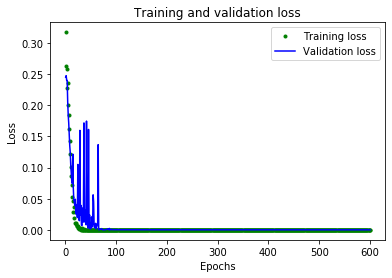

In [6]:
# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## tfliteにゆっくり変わって

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

## マイコンに入れるために「ANSI C」に変わって

In [7]:
_ = ! which xxd || apt-get install xxd
! xxd -i gesture_model.tflite > gesture_model.h
try:
    from google.colab import files
    files.download('gesture_model.h')
except Exception as e:
    from IPython.display import FileLink
    display(FileLink('gesture_model.h'))

/home/proppy/src/gesturestick/gesture_model.h

```
unsigned char gesture_model_data_tflite[][] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0xdc, 0x40, 0x02, 0x00, 0x10, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x2c, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  // ...
}
unsigned int gesture_model_tflite_len = 147764;
```

## TFLiteMicroのやり方

```
#include "tensorflow/lite/experimental/micro/kernels/all_ops_resolver.h"
#include "tensorflow/lite/experimental/micro/micro_error_reporter.h"
#include "tensorflow/lite/experimental/micro/micro_interpreter.h"
#include "tensorflow/lite/schema/schema_generated.h"
#include "tensorflow/lite/version.h"
```

## Modelをget
```
// ...
#include "gesture_model.h"


void setup() {
  // ...
  const tflite::Model* model = tflite::GetModel(g_gesture_model_data);
}
```

## MicroなんとかのInit

```
  uint8_t tensor_arena[8 * 1024];
  static tflite::MicroErrorReporter micro_error_reporter;
  tflite::ops::micro::AllOpsResolver resolver;

  tflite::MicroInterpreter interpreter(
      model, resolver, tensor_arena, sizeof(tensor_arena), error_reporter);
  TfLiteStatus allocate_status = interpreter.AllocateTensors();
```

## TFLiteそのまま

```
void loop() {
  M5.IMU.getAccelData(&aX,&aY,&aZ);
  M5.IMU.getGyroData(&gX,&gY,&gZ);
  
  TfLiteTensor* tflInputTensor = interpreter.input(0);
  tflInputTensor->data.f[samplesRead * 6 + 0] = (aX + 4.0) / 8.0;
  tflInputTensor->data.f[samplesRead * 6 + 1] = (aY + 4.0) / 8.0;
  tflInputTensor->data.f[samplesRead * 6 + 2] = (aZ + 4.0) / 8.0;
  tflInputTensor->data.f[samplesRead * 6 + 3] = (gX + 2000.0) / 4000.0;
  tflInputTensor->data.f[samplesRead * 6 + 4] = (gY + 2000.0) / 4000.0;
  tflInputTensor->data.f[samplesRead * 6 + 5] = (gZ + 2000.0) / 4000.0;
  
  samplesRead++;
  // ...
}
```

## TFLiteそのまま

```
    TfLiteTensor* tflOutputTensor = tflInterpreter->output(0);
    TfLiteStatus invokeStatus = tflInterpreter->Invoke();
    if (tflOutputTensor->data.f[0] > 0.8) {
        Serial.println("🙆(まる)");
    }
    if (tflOutputTensor->data.f[1] > 0.8) {
        Serial.println("🙅(ばつ)");
    }    
```